In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.linear_model import LinearRegression

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Inputs will be:

 - Load [MW]
 - Wind Excess [MW]
 - Wind Shortage [MW]
 - Previous State of Charge [MWh]
 - Previous Tank Holdup [kg]
 - Next 4, 8, 12, 16, 24 Hrs Excess
 - Next 4, 8, 12, 16, 24 Hrs Shortage

Outputs will be:

 - Ratio Battery Input to Nameplate [MW]
 - Ratio PEM Input to Nameplate [MW]
 - Ratio Battery Output to Nameplate [MW]
 - Ratio Turbine Output to Nameplate[MW]

In [2]:
import pandas as pd
import os
import json
from pathlib import Path
from dispatches.case_studies.renewables_h2_case.re_h2_parameters import re_h2_parameters, get_gen_outputs_from_rtsgmlc, kg_to_tons, h2_mols_per_kg


results_dir = Path("double_loop_317_CT_batth2")
with open(results_dir / "input_parameters.json", "r") as f:
    params = json.load(f)
year_results = pd.read_csv(results_dir / "design_timeseries_minsocfree.csv")
year_results.drop(columns="Unnamed: 0", inplace=True)
wind_gen = "317_WIND"
wind_gen_pmax = 799.1
gas_gen = "317_CT"
reserves = 15
shortfall = 500
start_date = '2020-01-01 00:00:00'
wind_cfs, wind_resource, loads_mw, wind_loads_mw = get_gen_outputs_from_rtsgmlc(wind_gen, gas_gen, reserves, shortfall, start_date)
loads_mw = loads_mw[0:len(year_results)]
year_results["Load [MW]"] = loads_mw
year_results["Wind Max [MW]"] = params['wind_mw'] * wind_cfs

In [3]:
print((year_results['Total Power Output [MW]'] - year_results['Load [MW]']).clip(upper=0).sum())
params['batt_mw'] = year_results['Battery Power Output [MW]'].max()
params['pem_mw'] = year_results['Wind Power to PEM [MW]'].max()
params['turb_mw'] = year_results['Turbine Power Output [MW]'].max()
year_results['Total Wind Generation [MW]'].max(), year_results['Battery Power Output [MW]'].max(), year_results['Turbine Power Output [MW]'].max(), year_results['Wind Power to PEM [MW]'].max()


-4.1744385725905886e-14


(929.8305543034136, 94.34833452736056, 45.98423635087665, 3.782219776052951)

In [4]:
import glob

columns = ["Design", "Wind MW", "Batt MW", "Batt MWh", "PEM MW", "Turb MW", "Tank Ton",
    "Capital Cost", "NPV",
    "Missed MW - Tank Target", "Missed MW - Min Op Cost", "Missed MW - Discharge Tank", "Missed MW - Discharge Batt", 
    "Missed MW - DTree"]
design_vs_op_df = pd.DataFrame(columns=columns)

designs = ("freeop", "modop", "minsoc", "minsocfree")
design_labels = ("No Constraint", "Charge Curtailed", "Min SOCs", "MinSOCs Free")
op_strats = ("tank_target_1", "min_op_cost_24", "discharge_tank_1", "discharge_batt_1", "dtree_12_1")

for design, label in zip(designs, design_labels):
    row = np.ones(len(columns) - 1)
    with open(results_dir / f"design_sizes_{design}.json", 'r') as f:
        des_res = json.load(f)
        row[0] = des_res['wind_mw']
        row[1] = des_res['batt_mw']
        row[2] = des_res['batt_mwh']
        row[3] = des_res['pem_mw']
        row[4] = des_res['turb_mw']
        row[5] = des_res['tank_tonH2']
        row[6] = des_res['capital_cost']
        row[7] = des_res['NPV']
    for i, op in enumerate(op_strats):
        try:
            row[8+i] = pd.read_csv(results_dir / f"{op}_{design}" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum()
        except:
            print(f"{op}_{design}")
    design_vs_op_df.loc[len(design_vs_op_df)] = [label] + row.tolist()

design_vs_op_df.set_index("Design", inplace=True)
design_vs_op_df

tank_target_1_minsocfree
dtree_12_1_minsocfree


,Wind MW,Batt MW,Batt MWh,PEM MW,Turb MW,Tank Ton,Capital Cost,NPV,Missed MW - Tank Target,Missed MW - Min Op Cost,Missed MW - Discharge Tank,Missed MW - Discharge Batt,Missed MW - DTree
Design,,,,,,,,,,,,,
No Constraint,953.841620,94.348335,834.609213,3.782220,45.984236,282.692485,5.877096e+08,-1.252251e+09,0.0,38328.0,2572.54,851.94,1083.95
Charge Curtailed,953.842213,103.096927,895.265167,3.467294,52.360659,301.099659,6.320095e+08,-1.499486e+09,0.0,0.0,2496.70,635.70,684.05
Min SOCs,953.842213,103.096927,959.280931,3.467294,52.360659,306.168548,6.579292e+08,-1.531415e+09,0.0,0.0,2435.88,624.42,181.73
MinSOCs Free,953.841620,94.348335,898.624976,3.782220,45.984236,287.761374,6.136293e+08,-1.284180e+09,1.0,0.0,2492.80,845.65,1.00


[]

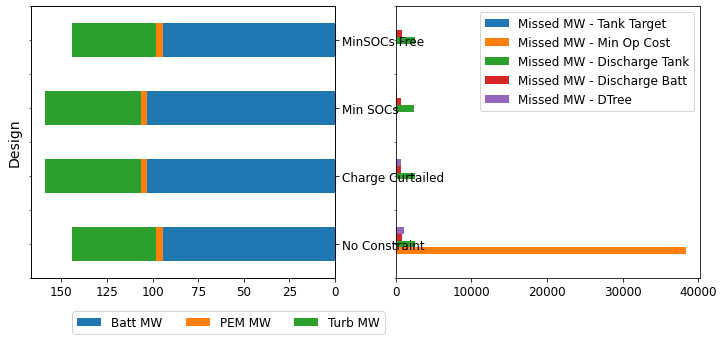

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
design_vs_op_df[["Batt MW", "PEM MW", "Turb MW"]].plot(kind='barh', stacked=True, ax=ax[0])
ax[0].invert_xaxis()
ax2 = ax[0].twinx()
ax2.set_ylim(ax[0].get_ylim())
ax2.set_yticks(ax[0].get_yticks())
ax2.set_yticklabels(ax[0].get_yticklabels())
ax[0].set_yticklabels([])
ax[0].set_yticks([])
ax[0].grid(False)
ax2.grid(False)
# plt.axis('off')
ax[0].legend(bbox_to_anchor=(.65,-0.1), loc="upper center", ncol=3)

design_vs_op_df[[ 'Missed MW - Tank Target',
       'Missed MW - Min Op Cost', 'Missed MW - Discharge Tank',
       'Missed MW - Discharge Batt', 'Missed MW - DTree']].plot(kind='barh', ax=ax[1])
ax[1].grid(False)

ax[1].set_yticklabels([])
ax[1].set_yticks([])


In [6]:
design_vs_op_df.columns

Index(['Wind MW', 'Batt MW', 'Batt MWh', 'PEM MW', 'Turb MW', 'Tank Ton',
       'Capital Cost', 'NPV', 'Missed MW - Tank Target',
       'Missed MW - Min Op Cost', 'Missed MW - Discharge Tank',
       'Missed MW - Discharge Batt', 'Missed MW - DTree'],
      dtype='object')

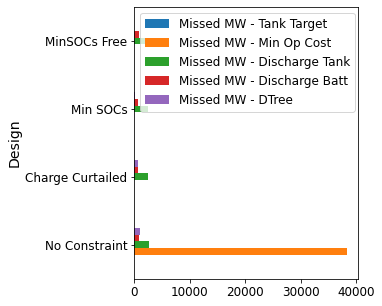

In [7]:
fig, ax = plt.subplots(figsize=(4, 5))
design_vs_op_df[[ 'Missed MW - Tank Target',
       'Missed MW - Min Op Cost', 'Missed MW - Discharge Tank',
       'Missed MW - Discharge Batt', 'Missed MW - DTree']].plot(kind='barh', ax=ax)
ax.grid(False)


tank target is ok
design opt is returning big batteries that aren't used in operation, which makes it easier for the operation models to succeed

In [8]:
print(pd.read_csv(results_dir / "tank_target_1_freeop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "discharge_tank_1_freeop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "discharge_batt_1_freeop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "dtree_12_1_freeop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "min_op_cost_24_freeop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())

0.0
2572.54
851.9399999999999
1083.95
38328.0


In [9]:
print(pd.read_csv(results_dir / "tank_target_1_modop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "discharge_tank_1_modop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "discharge_batt_1_modop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "dtree_12_1_modop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "min_op_cost_24_modop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())

0.0
2496.7
635.6999999999999
684.05
0.0


In [10]:
print(pd.read_csv(results_dir / "tank_target_1_minsoc" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "discharge_tank_1_minsoc" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "discharge_batt_1_minsoc" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "dtree_12_1_minsoc" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "min_op_cost_24_minsoc" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())

0.0
2435.88
624.42
181.73000000000002
0.0


In [11]:
year_results['Wind Excess [MW]'] = (year_results['Wind Max [MW]'] - year_results['Load [MW]']).clip(lower=0)
year_results['Wind Shortage [MW]'] = (year_results['Load [MW]'] - year_results['Wind Max [MW]']).clip(lower=0)
year_results['Previous State of Charge [MWh]'] = np.roll(year_results['State of Charge [MWh]'], 1)
year_results['Previous Tank Holdup [kg]'] = np.roll(year_results['Tank Holdup [kg]'], 1)
year_results['Ratio Battery Input to Nameplate [MW]'] = year_results['Wind Power to Battery [MW]'] / params['batt_mw']
year_results['Ratio PEM Input to Nameplate [MW]'] = year_results['Wind Power to PEM [MW]'] / params['pem_mw']
year_results['Ratio Battery Output to Nameplate [MW]'] = year_results['Battery Power Output [MW]'] / params['batt_mw']
year_results['Ratio Turbine Output to Nameplate [MW]'] = year_results['Turbine Power Output [MW]'] / params['turb_mw']

year_results['4-Hr Ahead Wind Excess [MW]'] = year_results['Wind Excess [MW]'][::-1].rolling(4, min_periods=0).sum()
year_results['16-Hr Ahead Wind Excess [MW]'] = year_results['Wind Excess [MW]'][::-1].rolling(16, min_periods=0).sum()
year_results['24-Hr Ahead Wind Excess [MW]'] = year_results['Wind Excess [MW]'][::-1].rolling(24, min_periods=0).sum()

year_results['4-Hr Ahead Wind Shortage [MW]'] = year_results['Wind Shortage [MW]'][::-1].rolling(4, min_periods=0).sum()
year_results['16-Hr Ahead Wind Shortage [MW]'] = year_results['Wind Shortage [MW]'][::-1].rolling(16, min_periods=0).sum()
year_results['24-Hr Ahead Wind Shortage [MW]'] = year_results['Wind Shortage [MW]'][::-1].rolling(24, min_periods=0).sum()

year_results.columns

input_cols = ['Previous State of Charge [MWh]', 'Previous Tank Holdup [kg]',
    'Wind Excess [MW]', 'Wind Shortage [MW]',  
    '4-Hr Ahead Wind Excess [MW]', 
    '16-Hr Ahead Wind Excess [MW]', '24-Hr Ahead Wind Excess [MW]',
    '4-Hr Ahead Wind Shortage [MW]', 
    '16-Hr Ahead Wind Shortage [MW]', '24-Hr Ahead Wind Shortage [MW]']
output_cols = ['Ratio Battery Input to Nameplate [MW]',
    'Ratio PEM Input to Nameplate [MW]',
    'Ratio Battery Output to Nameplate [MW]',
    'Ratio Turbine Output to Nameplate [MW]']

In [12]:
X = year_results[input_cols].to_numpy()
y = year_results[output_cols].to_numpy()

regtree = DecisionTreeRegressor(random_state=1, max_depth=12)
regfore = RandomForestRegressor(random_state=1, max_depth=10, n_estimators=2)
reglin = LinearRegression()

regtree.fit(X, y)
regfore.fit(X, y)
reglin.fit(X,y)

display(regtree.score(X, y), regfore.score(X, y), reglin.score(X, y))

# graph = graphviz.Source(export_graphviz(regtree, filled=True), format='png')
# graph.render("decision_tree_graphivz")

regtree.get_n_leaves()

0.9397588945510611

0.8443659322694707

0.2830136248583197

1119

In [13]:
sorted(list(zip(input_cols, regtree.feature_importances_)), key=lambda row: -row[1])

[('Wind Excess [MW]', 0.6683956431764829),
 ('Previous State of Charge [MWh]', 0.08925797556285822),
 ('16-Hr Ahead Wind Excess [MW]', 0.0625755846402589),
 ('Previous Tank Holdup [kg]', 0.05593585504358235),
 ('24-Hr Ahead Wind Excess [MW]', 0.053015025826297),
 ('4-Hr Ahead Wind Excess [MW]', 0.03305089916166141),
 ('Wind Shortage [MW]', 0.018976696735369145),
 ('24-Hr Ahead Wind Shortage [MW]', 0.013795656186580673),
 ('16-Hr Ahead Wind Shortage [MW]', 0.0043737582952529126),
 ('4-Hr Ahead Wind Shortage [MW]', 0.0006229053716565618)]

## Surrogate Model

In [14]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from pyvis.network import Network
from functools import reduce

from dispatches_sample_data import rts_gmlc
from dispatches.case_studies.renewables_case.double_loop_utils import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("deep")

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

pd.set_option('display.max_columns', None)

if os.environ.get("NREL_CLUSTER"):
    workspace_dir = Path("/projects/gmihybridsys/dguittet/workspace")
    dispatches_dir = Path("/projects/gmihybridsys/dguittet/dispatches/dispatches/case_studies/renewables_h2_case")
else:
    workspace_dir = Path("/Users/dguittet/Projects/Dispatches/workspace")
    dispatches_dir = Path("/Users/dguittet/Projects/Dispatches/dispatches/dispatches/case_studies/renewables_h2_case")

rts_gmlc_dir = workspace_dir / "prescient_runs/simulate_with_network_with_uncertainty_w_15_reserves_500_shortfall_eagle"

In [447]:
rts_gmlc_graph, line_df, branch_df, gen_df, summary = get_rtsgmlc_network(rts_gmlc_dir, rts_gmlc.source_data_path)
bus_dict = get_rtsgmlc_bus_dict(rts_gmlc.source_data_path)
bid_df = pd.read_csv(rts_gmlc.source_data_path / "gen.csv")
bid_df = bid_df[bid_df['Fuel'] == "NG"]
ng_gens = bid_df['GEN UID'].unique()
bid_df = bid_df.rename(columns={"GEN UID": "Generator"})

# heat rate compiling
bid_df["HR_avg_1"] = bid_df["HR_avg_0"] + bid_df["HR_incr_1"]
bid_df["HR_avg_2"] = bid_df["HR_avg_1"] + bid_df["HR_incr_2"]
bid_df["HR_avg_3"] = bid_df["HR_avg_1"] + bid_df["HR_incr_3"]
bid_df["HR_avg"] = (bid_df["HR_avg_0"] + bid_df["HR_avg_1"] + bid_df["HR_avg_2"] + bid_df["HR_avg_3"])/4

In [16]:
gen_df["Type"] = "NA"
gen_df.loc[gen_df['Generator'].str.contains("CC"), "Type"] = "CC"
gen_df.loc[gen_df['Generator'].str.contains("CT"), "Type"] = "CT"
gen_df[(gen_df["Type"] == "CT") | (gen_df["Type"] == "CC")].describe()

,Output,Output DA,Curtailment,Unit Market Revenue,Unit Uplift Payment,Dispatch,Dispatch DA,Headroom,Unit Cost
count,0.0,0.0,0.0,430416.000000,430416.0,430416.000000,430416.000000,430416.000000,430416.000000
mean,NaN,NaN,NaN,610.807387,0.0,15.804734,16.269232,12.121299,555.011400
std,NaN,NaN,NaN,2936.440500,0.0,53.792470,55.447145,42.560721,2369.660877
min,NaN,NaN,NaN,-9250.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,NaN,NaN,NaN,127406.477902,0.0,355.000000,355.000000,185.000000,35570.200971


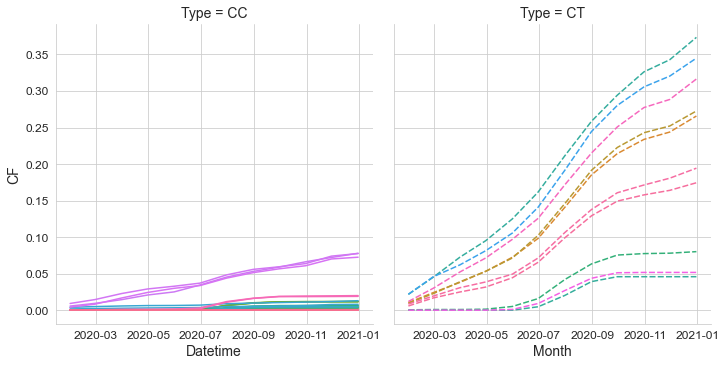

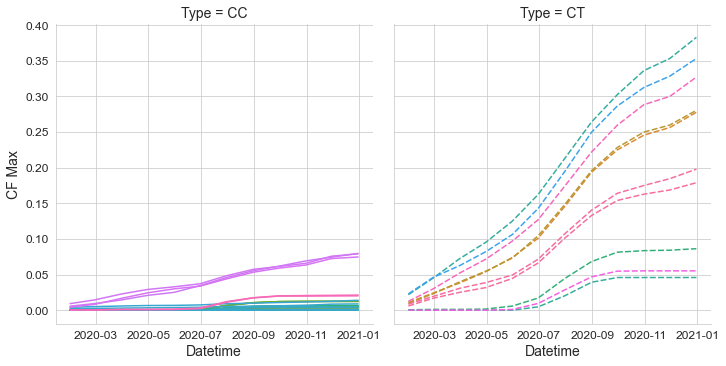

In [17]:
ng_df = gen_df.groupby("Generator").resample("1M").sum().reset_index()
ng_df["Dispatch Cml"] = ng_df.groupby('Generator').cumsum().reset_index()['Dispatch']
ng_df["Dispatch DA Cml"] = ng_df.groupby('Generator').cumsum().reset_index()['Dispatch DA']
ng_df["Type"] = "CC"
ng_df.loc[ng_df['Generator'].str.contains("CC"), "Type"] = "CT"

ng_df['CF'] = 0
for gen in ng_gens:
    ng_df.loc[ng_df['Generator'] == gen, "CF"] = ng_df.loc[ng_df['Generator'] == gen, "Dispatch Cml"] / bid_df[bid_df['Generator'] ==  gen]["PMax MW"].unique()[0] / 8760
    ng_df.loc[ng_df['Generator'] == gen, "CF Max"] = ng_df.loc[ng_df['Generator'] == gen][["Dispatch Cml", "Dispatch DA Cml"]].max(axis=1) / bid_df[bid_df['Generator'] ==  gen]["PMax MW"].unique()[0] / 8760


sns.relplot(
    data=ng_df, y="CF", x="Datetime", hue="Generator", style='Type',
    col="Type", kind="line", legend=False
)
plt.xlabel("Month")

sns.relplot(
    data=ng_df, y="CF Max", x="Datetime", hue="Generator", style='Type',
    col="Type", kind="line", legend=False
)

/Users/dguittet/miniconda3/envs/dispatches/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


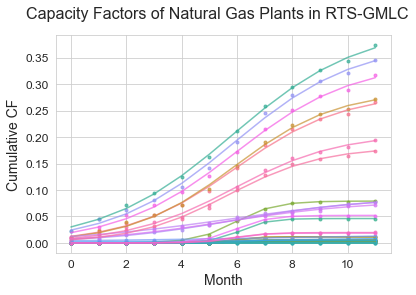

In [78]:
from scipy.optimize import curve_fit, least_squares

palette = sns.color_palette("husl", len(ng_gens))

def func(month, L, k, x_0):
    return L / (1 + np.exp(-k * (month - x_0)))

X = []
y = []
bid_df["L"] = np.nan
bid_df["L_abs"] = np.nan
bid_df["k"] = np.nan
bid_df['x_0'] = np.nan

fig = plt.figure()

xdata = np.array(range(0, 12)) / 12
for i, gen in enumerate(ng_gens):
    ydata = ng_df[ng_df['Generator'] == gen]['CF'].values
    pmax = bid_df[bid_df['Generator'] == gen]['PMax MW'].values[0]
    try:
        popt, pcov = curve_fit(func, xdata, ydata)
    except:
#         plt.plot(xdata, ydata, 'b-', label='data, no fit')
        continue
    # display(popt)
    plt.scatter(range(0, 12), ydata, label='data', marker='.', color=palette[i], alpha=0.7)
    plt.plot(range(0, 12), func(xdata, *popt), '-', label='fit: L=%5.3f, k=%5.3f, x_0=%5.3f' % tuple(popt), color=palette[i], alpha=0.7)
    # plt.legend()
    # X.append()
    if popt[1] < 0:
        continue
    bid_df.loc[bid_df['Generator'] == gen, "L"] = popt[0]
    bid_df.loc[bid_df['Generator'] == gen, "L_abs"] = popt[0] * pmax * 8760
    bid_df.loc[bid_df['Generator'] == gen, "k"] = popt[1]
    bid_df.loc[bid_df['Generator'] == gen, "x_0"] = popt[2]
    # break
plt.xlabel("Month")
plt.ylabel("Cumulative CF")
plt.suptitle("Capacity Factors of Natural Gas Plants in RTS-GMLC")

fit_df = bid_df.drop(columns=bid_df.columns[bid_df.isna().any()].tolist()[:-4])
fit_df = fit_df.dropna(axis=0)

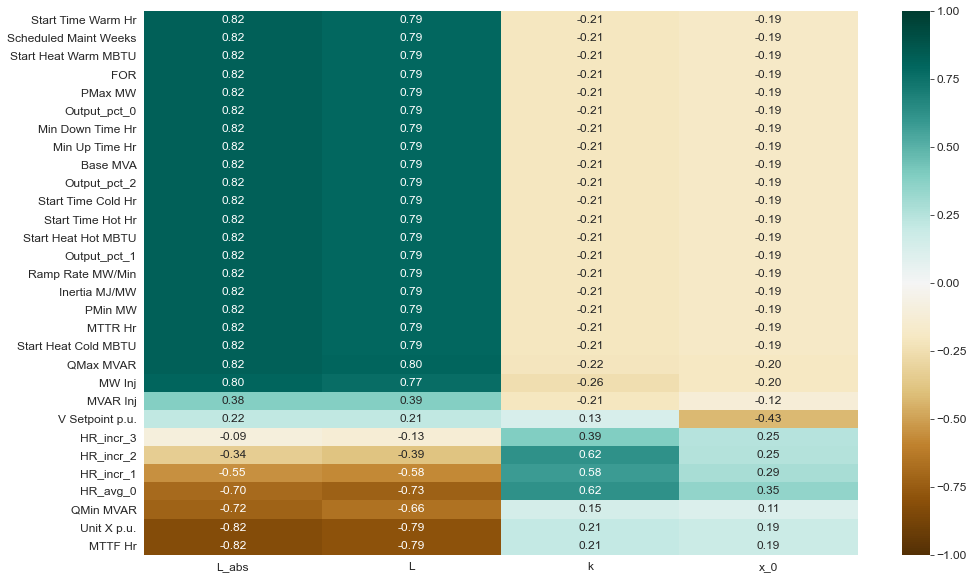

In [72]:
output_cols = ["L_abs", "L", 'k', 'x_0']
input_cols = set(fit_df.columns).difference(set(output_cols))
corr_df = fit_df.dropna(axis=1).drop(columns=["Bus ID", "Gen ID"])
corr_df = corr_df.corr().loc[corr_df.corr().index.isin(input_cols)][output_cols].dropna(axis=0)
input_cols = corr_df.index
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(corr_df.sort_values(by=output_cols, ascending=False), vmin=-1, vmax=1, cmap='BrBG', annot=True, fmt=".2f")


,L_abs,L,k,x_0
count,3.300000e+01,3.300000e+01,33.000000,33.000000
mean,2.189991e+05,8.090873e-02,53.949181,0.526446
std,3.929062e+05,1.227272e-01,139.173218,0.122055
min,1.089075e-164,2.260430e-170,1.000000,0.458390
25%,1.960216e+03,4.068526e-03,5.677240,0.490665
50%,8.210903e+03,1.704214e-02,23.428050,0.494997
75%,1.615857e+05,8.611018e-02,30.501825,0.497452
max,1.269082e+06,4.080911e-01,597.774117,0.999999


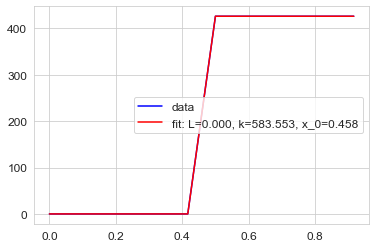

In [79]:
for i, tmp in fit_df.sort_values("x_0").head(1).iterrows():
    gen = tmp['Generator']
    ydata = ng_df[ng_df['Generator'] == gen]['CF'].values
    plt.figure()
    plt.plot(xdata, ydata * 8760 * pmax, 'b-', label='data')
    popt = tmp["L"], tmp['k'], tmp['x_0']
    plt.plot(xdata, func(xdata, *popt)* 8760 * pmax, 'r-', label='fit: L=%5.3f, k=%5.3f, x_0=%5.3f' % tuple(popt))
plt.legend()

fit_df[output_cols].describe()

## Figure out how to model the shape of the Sigmoids

In [97]:
bid_df[bid_df['Generator'].isin(ng_gens)]['PMax MW'].unique()

array([355.,  55.])

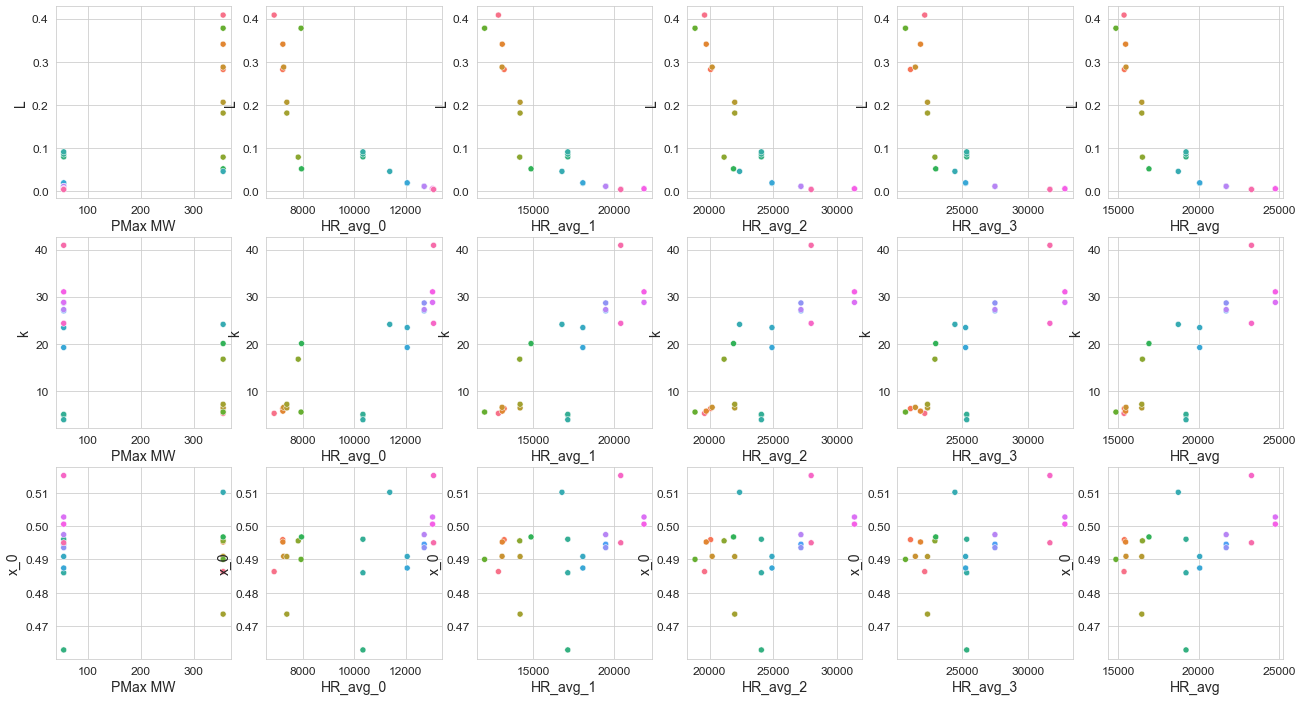

In [99]:
# drop some outliers
fit_df = fit_df.sort_values("HR_avg_0").head(-2)
fit_df = fit_df[fit_df['x_0'] < 0.6]

xvals = ["PMax MW", "HR_avg_0", "HR_avg_1", "HR_avg_2", "HR_avg_3", "HR_avg"]
# xvals = ["PMax MW", "HR_avg_0", "HR_incr_1", "HR_incr_2", "HR_incr_3", "HR_avg"]
yvals = ["L", "k", "x_0"]
fig, ax = plt.subplots(len(yvals), len(xvals), figsize=(22, 12))

for r, yval in enumerate(yvals):
    for c, xval in enumerate(xvals):
        sns.scatterplot(ax=ax[r, c],
            data=fit_df.sort_values("HR_avg_0"), y=yval, x=xval, hue="Generator", legend=False
        )

[ 0.99998173  0.9810049  21.08149406  0.58198517]


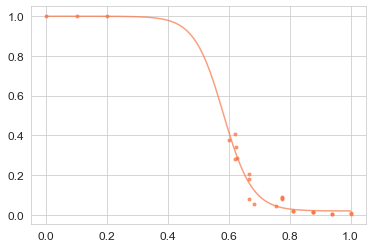

In [274]:
def func(x, A, b, c, d):
    return A - b / (1 + np.exp(-c * (x - d)))

xdata = np.append(fit_df['HR_avg'].values / fit_df['HR_avg'].max(), [0, 0.1, 0.2])
ydata = np.append(fit_df['L'].values, [1, 1, 1])
popt, pcov = curve_fit(func, xdata, ydata)
print(popt)
plt.scatter(xdata, ydata, label='data', marker='.', color=palette[i], alpha=0.7)
x = np.linspace(0, max(xdata), 100)
plt.plot(x, func(x, *popt), '-', label='fit: A=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt), color=palette[i], alpha=0.7)

In [535]:
fit_df['HR_avg'].mean()

19119.81818181818

[ 1.02457269  1.00285915 17.91238982  0.58524713  0.04870447]


/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_71124/2919807938.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks)
/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_71124/2919807938.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.array(ax.get_yticks() * fit_df['PMax MW'].max(), dtype='int'))


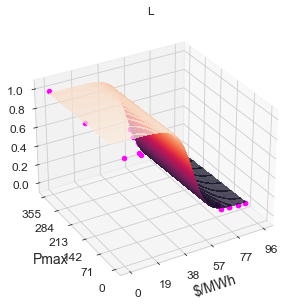

In [430]:
def funcL(x, a, b, c, d, e):
    return a - (b / (1 + np.exp(-c * (x[0] - d))) + (e * x[1]))

xdata1 = np.append(fit_df['PMax MW'].values / fit_df['PMax MW'].max(), [0, 0.5, 1])
xdata0 = np.append(fit_df['HR_avg'].values / fit_df['HR_avg'].max(), [0, 0, 0])
ydata = np.append(fit_df['L'].values, [1, 1, 1])

xdata = np.array(list(zip(xdata0, xdata1))).T
popt, pcov = curve_fit(funcL, xdata, ydata)
print(popt)

@np.vectorize
def fit_L(x, y):
    return funcL([x, y], *popt)
    
hr = np.linspace(0, fit_df["HR_avg"].max(), 200) / fit_df['HR_avg'].max()
pmax = np.linspace(fit_df['PMax MW'].min(), fit_df['PMax MW'].max(), 200) / fit_df['PMax MW'].max()

fig = plt.figure(figsize=(12, 5))
# sharex=True, sharey=True, projection='3d')
ax = fig.add_subplot(1, 2, 1, projection='3d')
X, Y = np.meshgrid(hr, pmax)

for x, y, z in zip(xdata0, xdata1, ydata):
    ax.scatter(x, y, z, marker='o', color='magenta')

Z = fit_L(X, Y)
g = ax.contourf(X, Y, Z, 200, alpha=0.7)
ax.set_xlabel("$/MWh")
ax.set_ylabel("Pmax")
ax.set_title("L")

xticks = np.array(ax.get_xticks() * fit_df['HR_avg'].max() * 3.88722 * 1e-3, dtype='int')
ax.set_xticklabels(xticks)
ax.set_yticklabels(np.array(ax.get_yticks() * fit_df['PMax MW'].max(), dtype='int'))
ax.view_init(elev=ax.elev, azim=60+180)


[4.087832   0.12620224 1.         1.        ]
[9.54938407 0.41719042 1.         1.        ]


/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_71124/3536742046.py:2: RuntimeWarning: overflow encountered in exp
  return np.exp(a * (x - b))
/Users/dguittet/miniconda3/envs/dispatches/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_71124/3536742046.py:2: RuntimeWarning: overflow encountered in exp
  return np.exp(a * (x - b))
/Users/dguittet/miniconda3/envs/dispatches/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0.5, 0, 'HR')

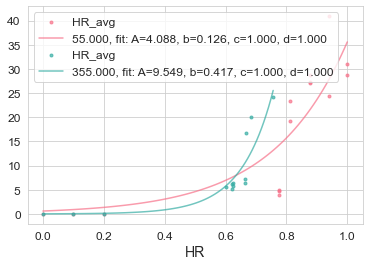

In [355]:
def func(x, a, b, c, d):
    return np.exp(a * (x - b)) 

palette = sns.color_palette("husl", 2)
for i, pmax in enumerate((55, 355)):
    xdata = np.append(fit_df[fit_df['PMax MW'] == pmax]['HR_avg'].values / fit_df['HR_avg'].max(), [0, 0.1, 0.2])
    ydata = np.append(fit_df[fit_df['PMax MW'] == pmax]['k'].values, [0, 0, 0])
    popt, pcov = curve_fit(func, xdata, ydata)
    print(popt)
    plt.scatter(xdata, ydata, label='HR_avg', marker='.', color=palette[i], alpha=0.7)
    x = np.linspace(0, max(xdata), 100)
    plt.plot(x, func(x, *popt), '-', label='%5.3f, fit: A=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % (pmax, *popt), color=palette[i], alpha=0.7)
plt.legend()
plt.xlabel("HR")

[4.49007315 0.40534523 0.9516349 ]


/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_71124/2997507720.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks)
/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_71124/2997507720.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.array(ax.get_yticks() * fit_df['PMax MW'].max(), dtype='int'))


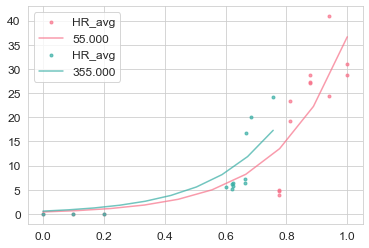

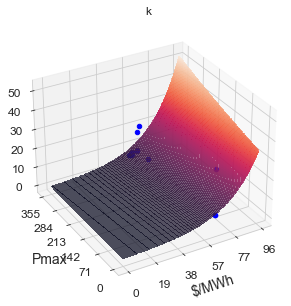

In [438]:
def funck(x, a, b, c):
    return np.exp(a * x[0] + b * x[1] - c)

xdata1 = np.append(fit_df['PMax MW'].values / fit_df['PMax MW'].max(), [0, 0.5, 1])
xdata0 = np.append(fit_df['HR_avg'].values / fit_df['HR_avg'].max(), [0, 0, 0])
ydata = np.append(fit_df['k'].values, [0, 0, 0])
xdata = np.array(list(zip(xdata0, xdata1))).T
popt, pcov = curve_fit(funck, xdata, ydata)
print(popt)

palette = sns.color_palette("husl", 2)
for i, pmax in enumerate((55, 355)):
    xdata = np.append(fit_df[fit_df['PMax MW'] == pmax]['HR_avg'].values / fit_df['HR_avg'].max(), [0, 0.1, 0.2])
    ydata = np.append(fit_df[fit_df['PMax MW'] == pmax]['k'].values, [0, 0, 0])
    plt.scatter(xdata, ydata, label='HR_avg', marker='.', color=palette[i], alpha=0.7)
    
    x = np.linspace(0, max(xdata), 10)
    xf = np.array(list(zip(x, [pmax / fit_df['PMax MW'].max()] * len(x)))).T
    y = funck(xf, *popt)
    plt.plot(x, y, '-', label='%5.3f' % pmax, color=palette[i], alpha=0.7)
plt.legend()

@np.vectorize
def fit_k(x, y):
    return funck([x, y], *popt)
    
hr = np.linspace(0, fit_df["HR_avg"].max(), 200) / fit_df['HR_avg'].max()
pmax = np.linspace(0, fit_df['PMax MW'].max(), 200) / fit_df['PMax MW'].max()

fig = plt.figure(figsize=(12, 5))
# sharex=True, sharey=True, projection='3d')
ax = fig.add_subplot(1, 2, 1, projection='3d')
X, Y = np.meshgrid(hr, pmax)

Z = fit_k(X, Y)
g = ax.contourf(X, Y, Z, 200, alpha=0.7)
ax.set_xlabel("$/MWh")
ax.set_ylabel("Pmax")
ax.set_title("k")

for x, y, z in zip(xdata0, xdata1, ydata):
    ax.scatter(x, y, z, marker='o', color='b')

xticks = np.array(ax.get_xticks() * fit_df['HR_avg'].max() * 3.88722 * 1e-3, dtype='int')
ax.set_xticklabels(xticks)
ax.set_yticklabels(np.array(ax.get_yticks() * fit_df['PMax MW'].max(), dtype='int'))
ax.view_init(elev=ax.elev, azim=60+180)

### Polynomial Fit

In [116]:
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer

input_cols = ['HR_avg', 
# 'HR_avg_0', 'HR_avg_1', 'HR_avg_2', 'HR_avg_3'
'PMax MW']

poly_fits = []
poly = PolynomialFeatures(1)

for i in range(1, 3):
    X = fit_df[input_cols].to_numpy()
    y = fit_df[output_cols[i]].to_numpy()

    X_poly = poly.fit_transform(X)
    # X_poly[:, 4] = 0
    regpoly = LinearRegression()
    regpoly.fit(X_poly, y)
    poly_fits.append(regpoly)
    
    print("score", regpoly.score(X_poly,y))
    print("predicted", regpoly.predict(poly.fit_transform([[11616, 200]])))
    print("coefs", sorted(list(zip(regpoly.coef_, poly.get_feature_names_out(input_cols))), key=lambda r: -abs(r[0])))
    print("intercept", regpoly.intercept_)

score 0.6846700610595398
predicted [0.34667497]
coefs [(0.00010975274011044269, 'PMax MW'), (-3.025599847037678e-05, 'HR_avg'), (0.0, '1')]
intercept 0.6761780976154577
score 0.754815619200743
predicted [-18.17320078]
coefs [(0.045976472293770665, 'PMax MW'), (0.004701359544632094, 'HR_avg'), (0.0, '1')]
intercept -81.97948770710629


/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_71124/4007084428.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(g, ax=axs[0])
/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_71124/4007084428.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(g, ax=axs[1])


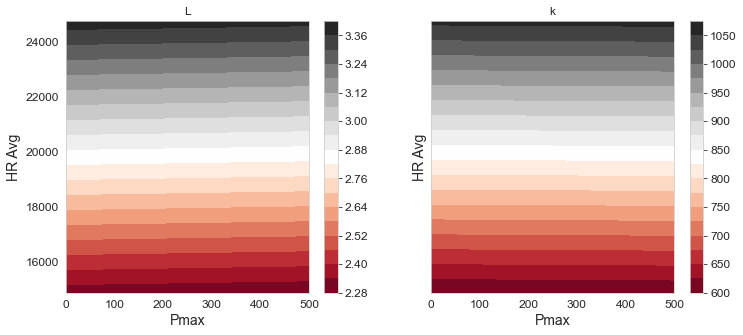

In [123]:
@np.vectorize
def fit_L(x, y):
    return poly_fits[0].predict(poly.fit_transform([[x, y]]))

@np.vectorize
def fit_x_0(x, y):
    return poly_fits[1].predict(poly.fit_transform([[x, y]]))

pmax = np.linspace(0, 500, 200)
hr = np.linspace(fit_df["HR_avg"].min(), fit_df["HR_avg"].max(), 200)

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
X, Y = np.meshgrid(pmax, hr)

Z = fit_L(X, Y)
g = axs[0].contourf(X, Y, Z, 20, cmap='RdGy')
axs[0].set_xlabel("Pmax")
axs[0].set_ylabel("HR Avg")
axs[0].set_title("L")
plt.colorbar(g, ax=axs[0])

Z = fit_x_0(X, Y)
g = axs[1].contourf(X, Y, Z, 20, cmap='RdGy')
axs[1].set_xlabel("Pmax")
axs[1].set_ylabel("HR Avg")
axs[1].set_title("k")
plt.colorbar(g, ax=axs[1])

/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_71124/4178741975.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


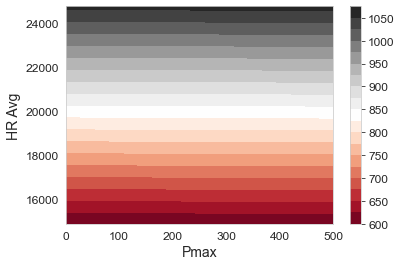

In [106]:
input_cols = ['HR_avg_0', 
# 'HR_avg_0', 'HR_avg_1', 'HR_avg_2', 'HR_avg_3'
'PMax MW']
 
for i in range(1, 3):
    X = fit_df[input_cols].to_numpy()
    y = fit_df[output_cols[i]].to_numpy()

    poly = PolynomialFeatures(1)
    X_poly = poly.fit_transform(X)
    # X_poly[:, 4] = 0
    regpoly = LinearRegression()
    regpoly.fit(X_poly, y)

    print("score", regpoly.score(X_poly,y))
    print("predicted", regpoly.predict(poly.fit_transform([[11616, 200]])))
    print("coefs", sorted(list(zip(regpoly.coef_, poly.get_feature_names_out(input_cols))), key=lambda r: -abs(r[0])))
    print("intercept", regpoly.intercept_, "\n")

score 0.7063787294436799
predicted [0.05257669]
coefs [(-4.6164748287704566e-05, 'HR_avg_0'), (-3.966950375047242e-06, 'PMax MW'), (0.0, '1')]
intercept 0.5896197971813614 

score 0.7997237897667058
predicted [27.21941183]
coefs [(0.060831799179434744, 'PMax MW'), (0.006976460771225472, 'HR_avg_0'), (0.0, '1')]
intercept -65.9855163268486 



In [103]:
display(fit_df[input_cols + output_cols].corr())
display(fit_df.sort_values("HR_avg_0")[input_cols + output_cols].tail())
fit_df[output_cols].describe()

,HR_avg_0,PMax MW,L_abs,L,k,x_0
HR_avg_0,1.000000,-0.880060,-0.826271,-0.840461,0.805256,0.360350
PMax MW,-0.880060,1.000000,0.788157,0.738649,-0.523974,-0.046424
L_abs,-0.826271,0.788157,1.000000,0.985925,-0.652923,-0.191048
L,-0.840461,0.738649,0.985925,1.000000,-0.748276,-0.274511
k,0.805256,-0.523974,-0.652923,-0.748276,1.000000,0.513596
x_0,0.360350,-0.046424,-0.191048,-0.274511,0.513596,1.000000


,HR_avg_0,PMax MW,L_abs,L,k,x_0
22,12725.0,55.0,5505.118670,0.011426,27.237153,0.497452
30,13051.0,55.0,3044.523836,0.006319,28.775114,0.502737
31,13051.0,55.0,2795.717603,0.005803,31.011931,0.500597
48,13090.0,55.0,2321.168317,0.004818,24.327395,0.515198
49,13090.0,55.0,1993.439351,0.004137,40.902075,0.494997


,L_abs,L,k,x_0
count,2.200000e+01,22.000000,22.000000,22.000000
mean,3.272115e+05,0.118692,16.707877,0.493075
std,4.454555e+05,0.135802,11.355040,0.010791
min,1.993439e+03,0.004137,3.852472,0.462813
25%,5.530248e+03,0.011478,5.812277,0.490227
50%,4.272586e+04,0.065518,17.953088,0.494782
75%,6.217041e+05,0.199918,26.323754,0.496578
max,1.269082e+06,0.408091,40.902075,0.515198


In [32]:
regpoly.predict(poly.fit_transform(X))

array([-26.78617823,  71.46022559,  71.46022559,  71.46022559,
        71.46022559, -24.70043186,  47.62312419,  47.62312419,
        47.62312419,  67.05036184,  67.05036184,   9.08865937,
        71.46022559,  71.46022559, 221.29845459, -46.74975066,
       468.88429868, 468.88429868,  69.37447922,  69.37447922,
        85.04737339,  85.04737339,  15.64386226, -94.3864074 ,
       -94.3864074 , -94.3864074 ,  16.71653182, -26.48821447,
         8.23231413,   8.23231413, -17.31093043, -17.31093043])

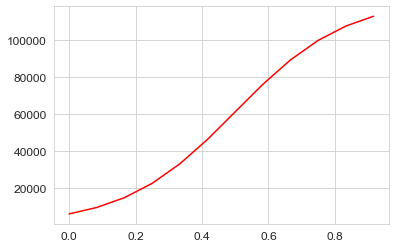

In [33]:
plt.figure()
popt = 0.03932, 5.9747, 0.5, 0, 0
plt.plot(xdata, func(xdata, *popt)* 8760 * pmax, 'r-', label='fit: L=%5.3f, k=%5.3f, x_0=%5.3f, a=%5.3f, b=%5.3f' % tuple(popt))

In [34]:
input_cols = [['HR_avg_0', 'HR_incr_1', 'HR_incr_2'],
            ['HR_incr_2', 'HR_incr_3', 'HR_avg_0'],
            ['HR_avg_0', 'HR_incr_1', 'HR_incr_2']]
 
for i in range(1, 4):
    X = fit_df[input_cols[i-1]].to_numpy()
    y = fit_df[output_cols[i]].to_numpy()

    regtree = DecisionTreeRegressor(random_state=1)
    regtree.fit(X, y)

    poly = PolynomialFeatures(2)
    X_poly = poly.fit_transform(X)
    regpoly = LinearRegression()
    regpoly.fit(X_poly, y)

    display(regtree.score(X, y), regpoly.score(X_poly,y))
    display(sorted(list(zip(input_cols[i-1], regtree.feature_importances_)), key=lambda row: -row[1])[0:10])
    display(sorted(list(zip(regpoly.coef_, poly.get_feature_names_out(input_cols[i-1]))), key=lambda r: -abs(r[0]))[0:10])
    display(regpoly.intercept_)    

0.9991775138273445

0.9235538152034884

[('HR_avg_0', 0.8379379553608413),
 ('HR_incr_1', 0.13518354426538326),
 ('HR_incr_2', 0.02687850037377545)]

[(-0.0005530116501883573, 'HR_incr_1'),
 (0.00039970639741161316, 'HR_incr_2'),
 (-0.00013340776436386218, 'HR_avg_0'),
 (1.0130520755894108e-07, 'HR_incr_1 HR_incr_2'),
 (-6.652531617594743e-08, 'HR_incr_1^2'),
 (5.9059127521706714e-08, 'HR_avg_0 HR_incr_1'),
 (-5.241336074724642e-08, 'HR_incr_2^2'),
 (-2.594728769271217e-08, 'HR_avg_0 HR_incr_2'),
 (-4.944897262723646e-09, 'HR_avg_0^2'),
 (0.0, '1')]

1.501384996648301

0.9987792124279308

0.9946452749231666

[('HR_avg_0', 0.9996117581519194),
 ('HR_incr_2', 0.0003605927942086363),
 ('HR_incr_3', 2.7649053871950638e-05)]

[(-0.21272584613156223, 'HR_incr_2'),
 (-0.1719720469460552, 'HR_avg_0'),
 (-0.01147721160802191, 'HR_incr_3'),
 (-3.597628113240561e-05, 'HR_incr_2 HR_incr_3'),
 (2.661748164822439e-05, 'HR_incr_2^2'),
 (1.2262740669455319e-05, 'HR_incr_2 HR_avg_0'),
 (1.0591135229304216e-05, 'HR_incr_3^2'),
 (6.115038514123428e-06, 'HR_incr_3 HR_avg_0'),
 (1.6113006688633913e-06, 'HR_avg_0^2'),
 (0.0, '1')]

1826.6370773294511

0.8399053029337732

0.2943520290699585

[('HR_incr_2', 0.6336291839296514),
 ('HR_avg_0', 0.3634252447122969),
 ('HR_incr_1', 0.0029455713580516826)]

[(0.0016238840317316949, 'HR_incr_2'),
 (-0.0014843534679819723, 'HR_incr_1'),
 (0.00011661019024086907, 'HR_avg_0'),
 (2.0492615450633612e-07, 'HR_incr_1 HR_incr_2'),
 (-1.732808702447747e-07, 'HR_incr_2^2'),
 (-5.286175825139973e-08, 'HR_avg_0 HR_incr_2'),
 (3.04491412675989e-08, 'HR_avg_0 HR_incr_1'),
 (-1.70508665969114e-08, 'HR_incr_1^2'),
 (3.6878851264438668e-09, 'HR_avg_0^2'),
 (0.0, '1')]

-1.1520517250751554

In [ ]:
# m.L = pyo.Expression(expr=sum([(-0.00013157516117854665 * m.HR_avg_0),
#                                 (-2.2592344881735425e-07 * m.PMaxMW ** 2),
#                                 (4.034252620659616e-09 * m.HR_avg_0 ** 2),
#                                 (-5.510328020461569e-10 * m.PMaxMW)]) + 1.032387)
# m.k = pyo.Expression(expr=sum([(-0.18430594283973323 * m.HR_avg_0),
#                                 (-0.002965030619685851 * m.PMaxMW ** 2),
#                                 (0.0001159065923267955 * m.HR_avg_0 * m.PMaxMW),
#                                 (7.9612192342704e-06 * m.HR_avg_0 ** 2),
#                                 (-7.231782002169402e-06 * m.PMaxMW)]) + 1005.174)

## Fit Revenue

In [453]:
gen_df["LMP DA"] = np.nan
gen_df["LMP"] = np.nan
for gen in ng_df.Generator.unique():
    bus = gen[0:3]
    bus_name = bus_dict[int(bus)]
    gen_df.loc[gen_df["Generator"] == gen, "LMP DA"] = summary[summary['Bus'] == bus_name]["LMP DA"].values
    gen_df.loc[gen_df["Generator"] == gen, "LMP"] = summary[summary['Bus'] == bus_name]["LMP"].values

In [494]:
gen_df['Revenue DA'] = gen_df['Dispatch DA'] * gen_df['LMP DA']
gen_df['Revenue RT'] = (gen_df['Dispatch'] - gen_df['Dispatch DA']) * gen_df['LMP']
gen_df['Revenue'] = gen_df['Revenue RT']  + gen_df['Revenue DA']
gen_df['Revenue Per MWh'] = gen_df['Revenue'] / gen_df[['Dispatch', 'Dispatch DA']].max(axis=1)
gen_df['Revenue DA Per MWh'] = gen_df['Revenue DA'] / gen_df['Dispatch DA']
gen_df['Revenue RT Per MWh'] = gen_df['Revenue RT'] / gen_df['Dispatch']

gen_monthly = gen_df.groupby("Generator").resample('1M').mean().reset_index()
gen_monthly["Type"] = "NA"
gen_monthly.loc[gen_monthly['Generator'].str.contains("CC"), "Type"] = "CC"
gen_monthly.loc[gen_monthly['Generator'].str.contains("CT"), "Type"] = "CT"
gen_monthly = gen_monthly[gen_monthly['Generator'].isin(bid_df.Generator.unique())]

for gen in bid_df.Generator.unique():
    bus = gen[0:3]
    gen_monthly.loc[gen_monthly['Generator'] == gen, "Bus"] = bus_dict[int(bus)]
    gen_monthly.loc[gen_monthly['Generator'] == gen, "HR_avg"] = bid_df[bid_df['Generator'] == gen]["HR_avg"].values[0]
    gen_monthly.loc[gen_monthly['Generator'] == gen, "PMax MW"] = bid_df[bid_df['Generator'] == gen]["PMax MW"].values[0]

gen_monthly['Revenue RT Per MWh'] = gen_monthly['Revenue RT Per MWh'].fillna(0)
gen_monthly['Revenue DA Per MWh'] = gen_monthly['Revenue DA Per MWh'].fillna(0)
gen_monthly['Revenue Per MWh'] = gen_monthly['Revenue Per MWh'].fillna(0)
gen_monthly["LMP Max"] = gen_monthly[["LMP", "LMP DA"]].max(axis=1)

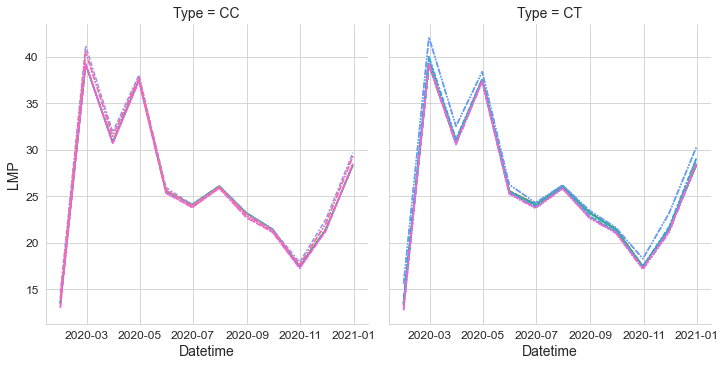

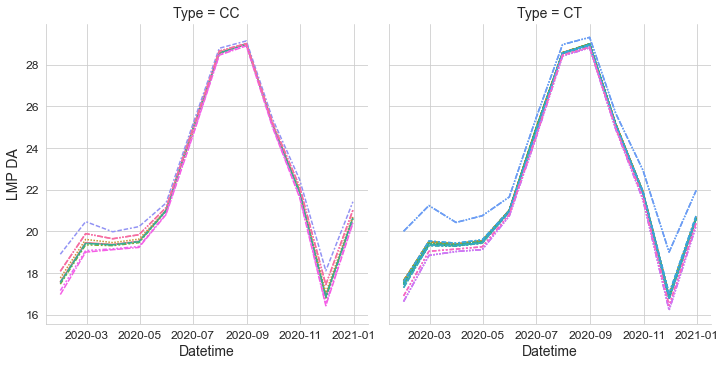

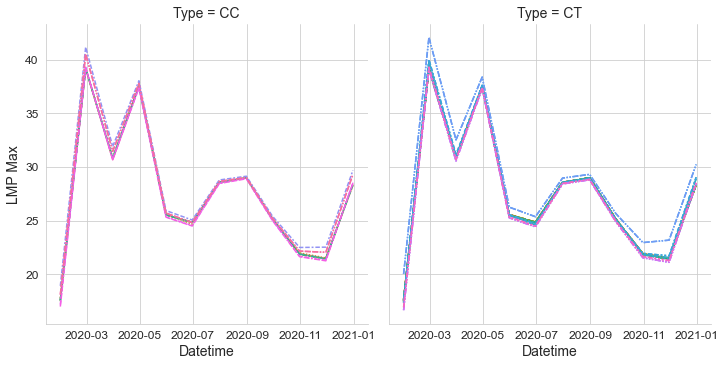

In [477]:
sns.relplot(
    data=gen_monthly, y="LMP", x="Datetime", hue="Generator", style='Bus',
    col="Type", kind="line", legend=False
)
sns.relplot(
    data=gen_monthly, y="LMP DA", x="Datetime", hue="Generator", style='Bus',
    col="Type", kind="line", legend=False
)
sns.relplot(
    data=gen_monthly, y="LMP Max", x="Datetime", hue="Generator", style='Bus',
    col="Type", kind="line", legend=False
)

In [483]:
gen_monthly.HR_avg.unique()

array([15386.  , 22149.  , 15485.75, 21709.  , 24763.  , 16506.5 ,
       23082.  , 18734.25, 15365.75, 32215.5 , 23279.75, 26868.  ,
       22895.75, 14860.75, 19214.5 , 16913.5 , 15462.5 , 20064.5 ,
       16468.  ])

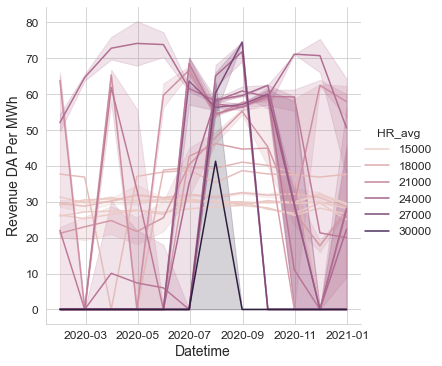

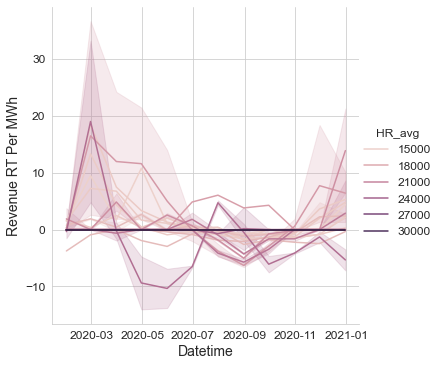

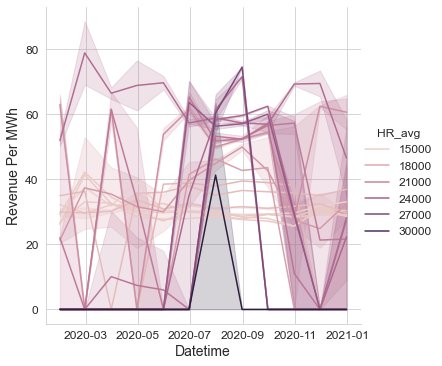

In [487]:
sns.relplot(
    data=gen_monthly, y="Revenue DA Per MWh", x="Datetime", hue="HR_avg",
    kind="line", legend=True
)

sns.relplot(
    data=gen_monthly, y="Revenue RT Per MWh", x="Datetime", hue="HR_avg",
    kind="line", legend=True
)

sns.relplot(
    data=gen_monthly, y="Revenue Per MWh", x="Datetime", hue="HR_avg",
    kind="line", legend=True
)

In [493]:
gen_monthly.columns

Index(['Generator', 'Datetime', 'Output', 'Output DA', 'Curtailment',
       'Unit Market Revenue', 'Unit Uplift Payment', 'Dispatch', 'Dispatch DA',
       'Headroom', 'Unit Cost', 'LMP DA', 'LMP', 'Revenue DA', 'Revenue RT',
       'Revenue', 'Revenue Per MWh', 'Revenue DA Per MWh',
       'Revenue RT Per MWh', 'Type', 'Bus', 'HR_avg', 'LMP Max', 'HR_avg_rnd'],
      dtype='object')

In [496]:
gen_monthly['HR_avg_rnd'] = (gen_monthly['HR_avg'] * 1e-3).round() * 1e3
gen_monthly['HR_avg_rnd'].unique()

array([15000., 22000., 25000., 17000., 23000., 19000., 32000., 27000.,
       20000., 16000.])

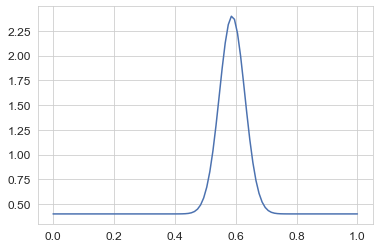

In [532]:
x = np.linspace(0, 1, 100)
plt.plot(x, 2 * np.exp(-(17*x-10)**2) + .4)

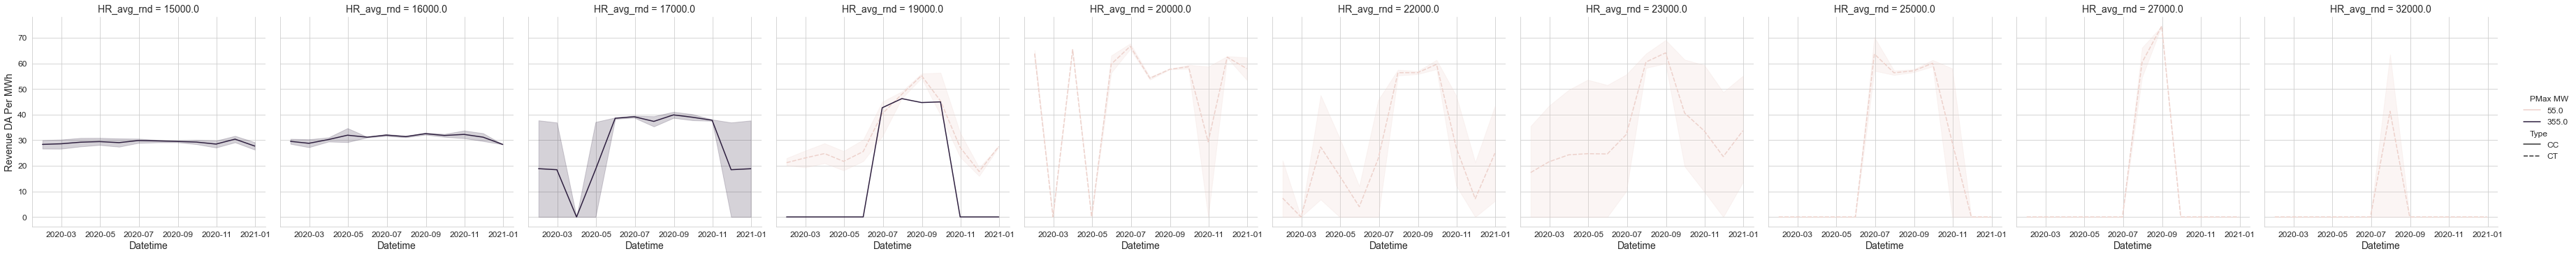

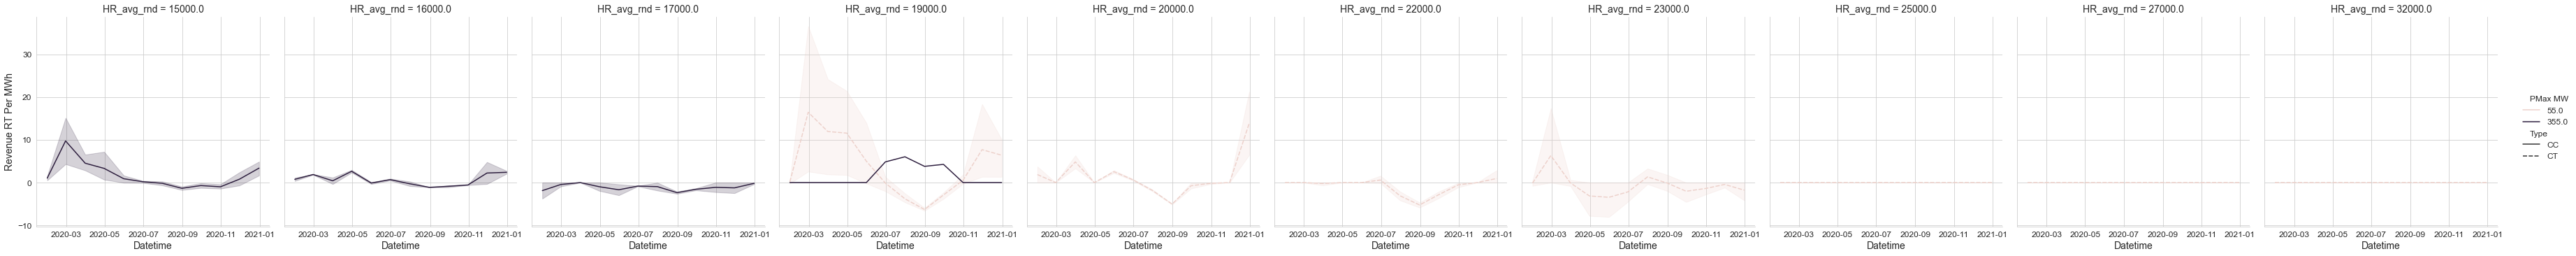

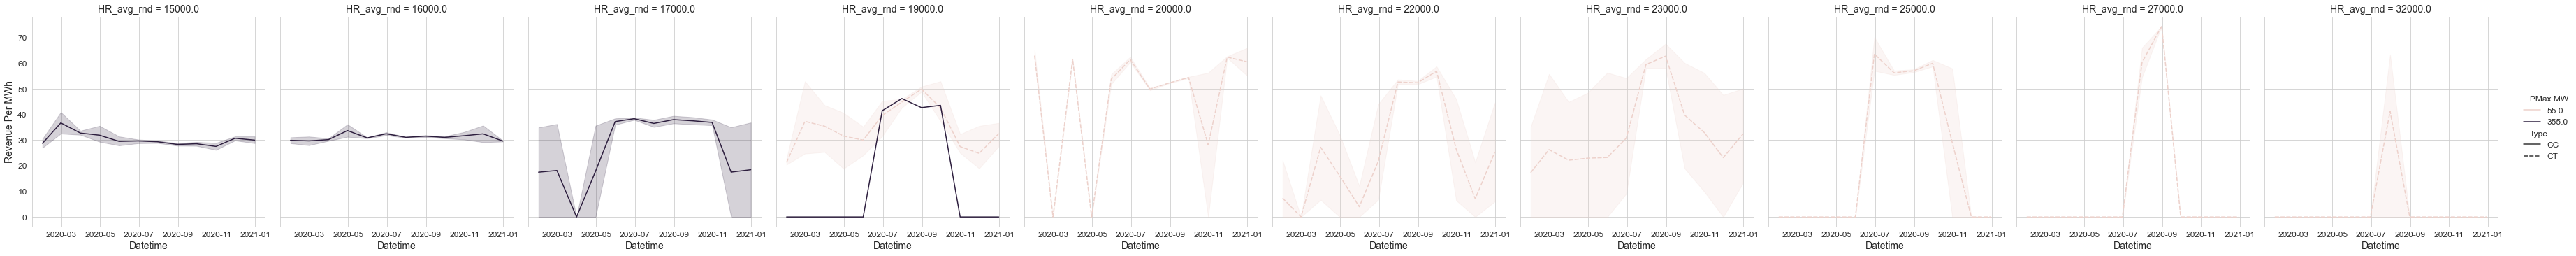

In [497]:
sns.relplot(
    data=gen_monthly, y="Revenue DA Per MWh", x="Datetime", hue="PMax MW", style="Type",
    col="HR_avg_rnd", kind="line", legend=True
)

sns.relplot(
    data=gen_monthly, y="Revenue RT Per MWh", x="Datetime", hue="PMax MW",style="Type",
    col="HR_avg_rnd", kind="line", legend=True
)

sns.relplot(
    data=gen_monthly, y="Revenue Per MWh", x="Datetime", hue="PMax MW",style="Type",
    col="HR_avg_rnd", kind="line", legend=True
)

/Users/dguittet/miniconda3/envs/dispatches/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/dguittet/miniconda3/envs/dispatches/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_71124/463330225.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/dguittet/miniconda3/envs/dispatches/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the paramet

Text(0.5, 0.98, 'Revenue per MWh of Natural Gas Plants in RTS-GMLC')

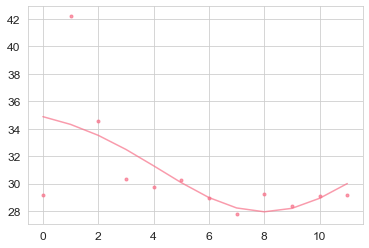

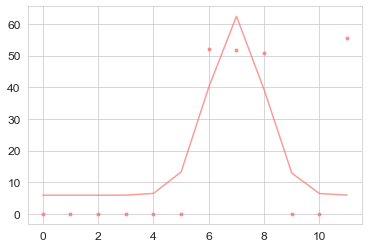

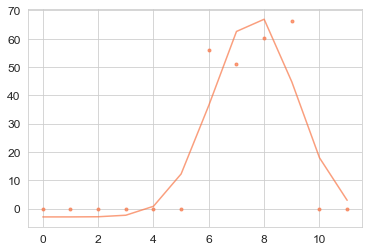

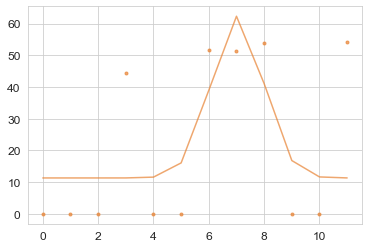

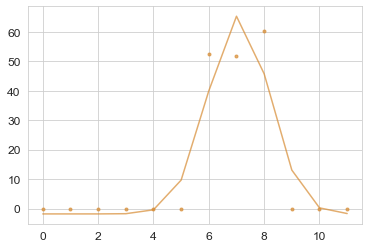

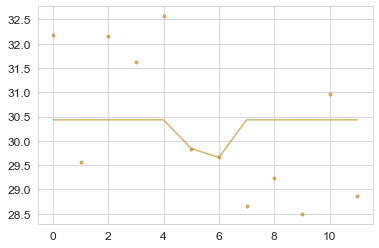

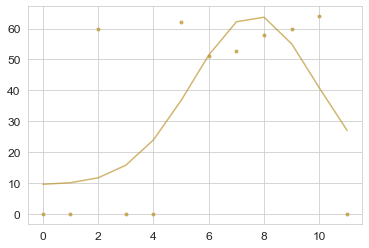

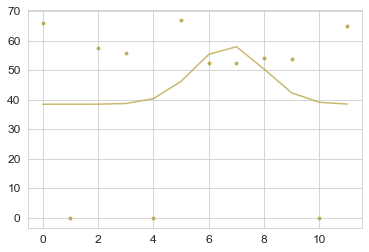

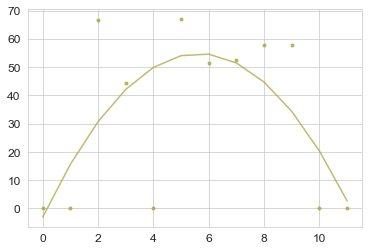

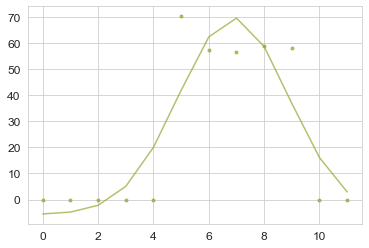

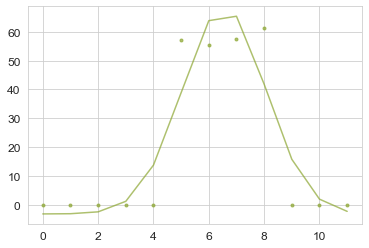

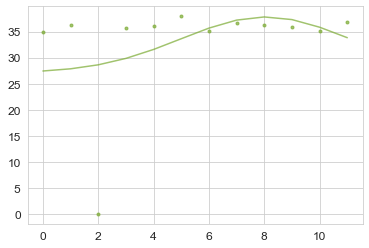

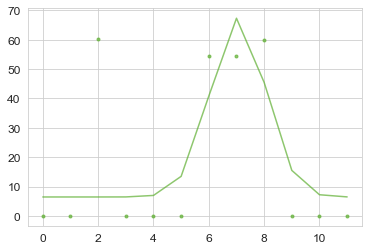

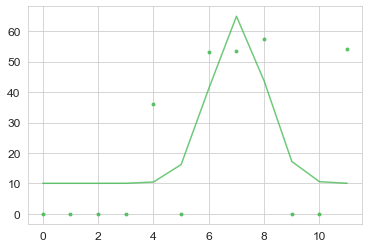

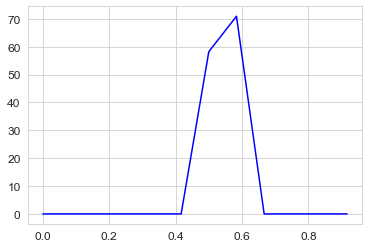

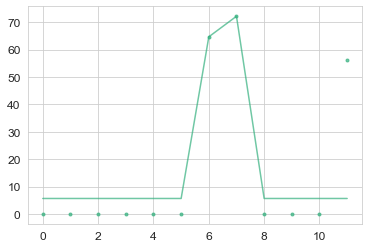

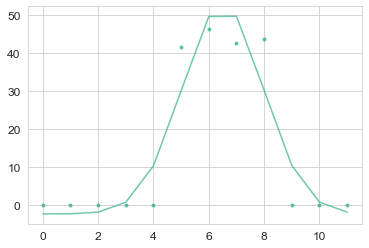

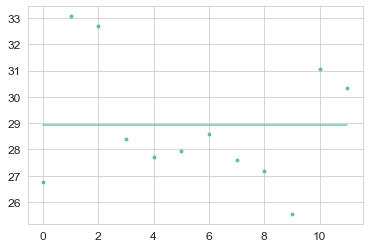

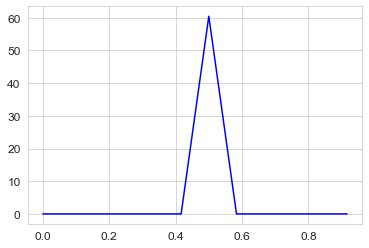

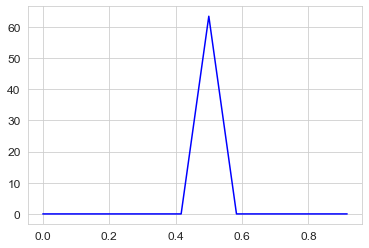

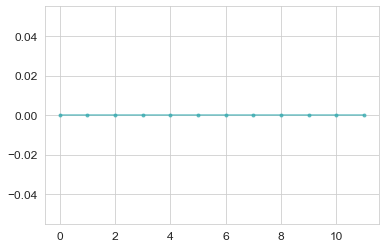

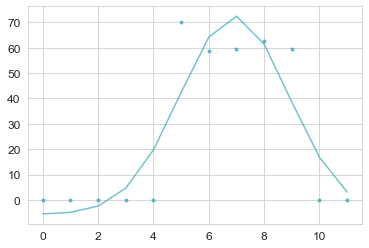

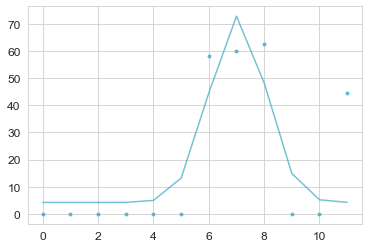

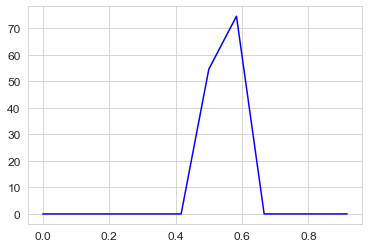

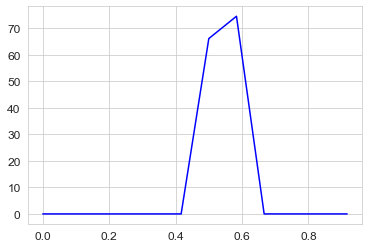

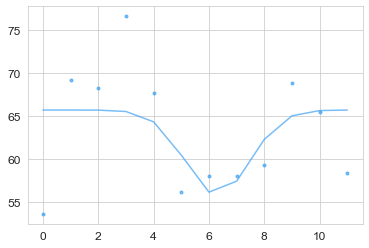

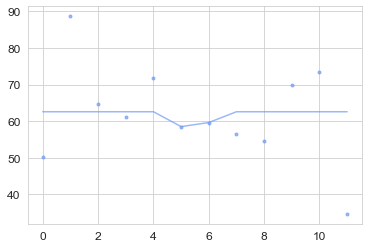

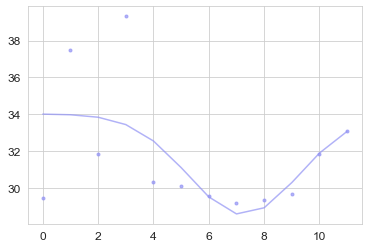

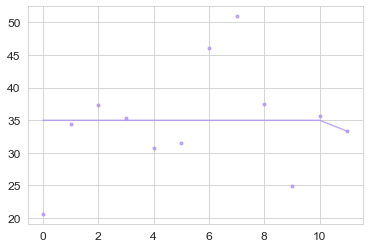

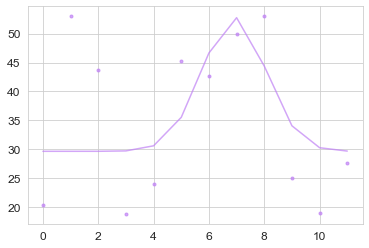

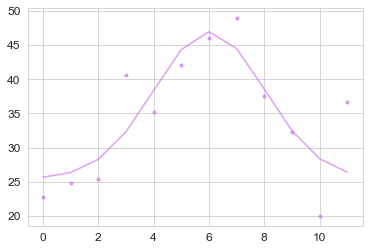

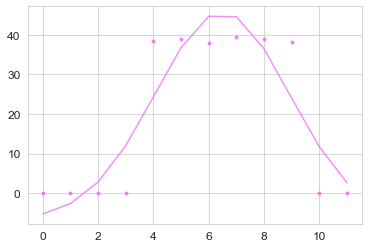

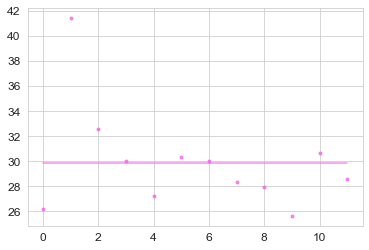

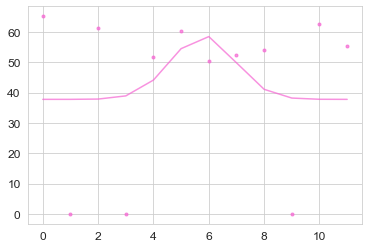

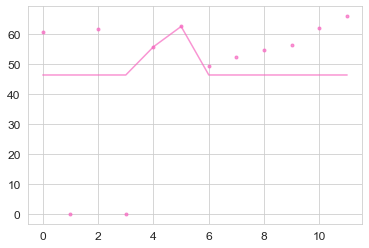

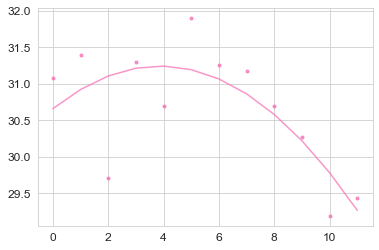

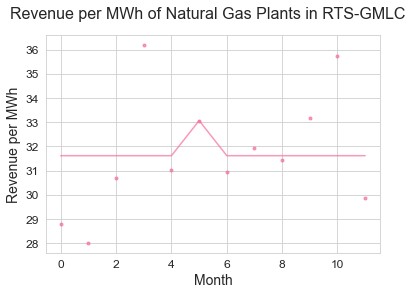

In [533]:
from scipy.optimize import curve_fit, least_squares

palette = sns.color_palette("husl", len(ng_gens))

def func(month, a, b, c, d):
    return a * np.exp(-(b*month-c)**2) + d

X = []
y = []
bid_df["a"] = np.nan
bid_df["b"] = np.nan
bid_df["c"] = np.nan
bid_df['d'] = np.nan


xdata = np.array(range(0, 12)) / 12
for i, gen in enumerate(gen_monthly.Generator.unique()):
    ydata = gen_monthly[gen_monthly['Generator'] == gen]['Revenue Per MWh'].values
    pmax = bid_df[bid_df['Generator'] == gen]['PMax MW'].values[0]

    fig = plt.figure()
    try:
        p0 = [
            ydata.max() - ydata.min(),
            20,
            10, 
            max(ydata.min(), 0)
        ]
        popt, pcov = curve_fit(func, xdata, ydata, p0=p0)
    except:
        plt.plot(xdata, ydata, 'b-', label='data, no fit')
        continue
    # display(popt)
    plt.scatter(range(0, 12), ydata, label='data', marker='.', color=palette[i], alpha=0.7)
    plt.plot(range(0, 12), func(xdata, *popt), '-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt), color=palette[i], alpha=0.7)
    # plt.legend()
    # X.append()
    if popt[1] < 0:
        continue
    bid_df.loc[bid_df['Generator'] == gen, "a"] = popt[0]
    bid_df.loc[bid_df['Generator'] == gen, "b"] = popt[0] * pmax * 8760
    bid_df.loc[bid_df['Generator'] == gen, "c"] = popt[1]
    bid_df.loc[bid_df['Generator'] == gen, "d"] = popt[2]
    # break
plt.xlabel("Month")
plt.ylabel("Revenue per MWh")
plt.suptitle("Revenue per MWh of Natural Gas Plants in RTS-GMLC")

# fit_df = bid_df.drop(columns=bid_df.columns[bid_df.isna().any()].tolist()[:-4])
# fit_df = fit_df.dropna(axis=0)

In [ ]:
def funcL(x, a, b, c, d, e):
    return a * np.exp(-(b*x-c)**2) + d

xdata0 = np.append(fit_df['HR_avg'].values / fit_df['HR_avg'].max(), [0, 0, 0])
xdata1 = np.append(fit_df['PMax MW'].values / fit_df['PMax MW'].max(), [0, 0.5, 1])
ydata = np.append(fit_df['L'].values, [1, 1, 1])

xdata = np.array(list(zip(xdata0, xdata1))).T
popt, pcov = curve_fit(funcL, xdata, ydata)
print(popt)

@np.vectorize
def fit_L(x, y):
    return funcL([x, y], *popt)
    
hr = np.linspace(0, fit_df["HR_avg"].max(), 200) / fit_df['HR_avg'].max()
pmax = np.linspace(fit_df['PMax MW'].min(), fit_df['PMax MW'].max(), 200) / fit_df['PMax MW'].max()

fig = plt.figure(figsize=(12, 5))
# sharex=True, sharey=True, projection='3d')
ax = fig.add_subplot(1, 2, 1, projection='3d')
X, Y = np.meshgrid(hr, pmax)

for x, y, z in zip(xdata0, xdata1, ydata):
    ax.scatter(x, y, z, marker='o', color='magenta')

Z = fit_L(X, Y)
g = ax.contourf(X, Y, Z, 200, alpha=0.7)
ax.set_xlabel("$/MWh")
ax.set_ylabel("Pmax")
ax.set_title("L")

xticks = np.array(ax.get_xticks() * fit_df['HR_avg'].max() * 3.88722 * 1e-3, dtype='int')
ax.set_xticklabels(xticks)
ax.set_yticklabels(np.array(ax.get_yticks() * fit_df['PMax MW'].max(), dtype='int'))
ax.view_init(elev=ax.elev, azim=60+180)


### Get average shape and then translate up or down as average translation per generator

Text(0, 0.5, '$/MWh')

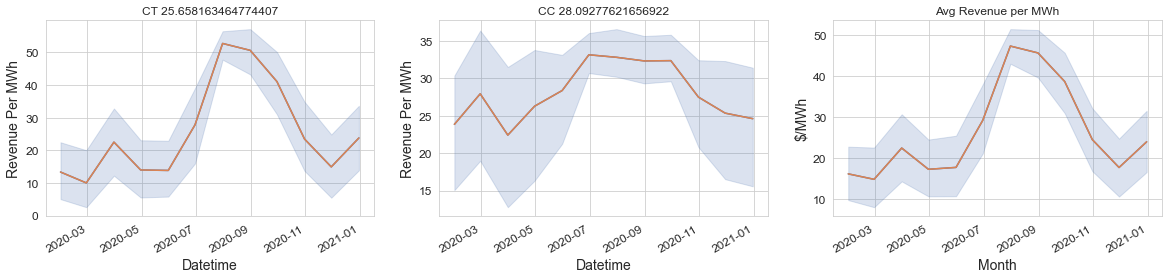

In [482]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4), sharex=True)
sns.lineplot(data=gen_monthly[gen_monthly['Type'] == "CT"], x='Datetime', y='Revenue Per MWh', ax=axs[0])
avg_revenue_per_mwh = gen_monthly[gen_monthly['Type'] == "CT"].groupby("Datetime").mean()['Revenue Per MWh']
avg_revenue_per_mwh.plot(title="CT "+str(avg_revenue_per_mwh.mean()), ax=axs[0])

sns.lineplot(data=gen_monthly[gen_monthly['Type'] == "CC"], x='Datetime', y='Revenue Per MWh', ax=axs[1])
avg_revenue_per_mwh = gen_monthly[gen_monthly['Type'] == "CC"].groupby("Datetime").mean()['Revenue Per MWh']
avg_revenue_per_mwh.plot(title="CC "+str(avg_revenue_per_mwh.mean()), ax=axs[1])

sns.lineplot(data=gen_monthly, x='Datetime', y='Revenue Per MWh', ax=axs[2])
avg_revenue_per_mwh = gen_monthly.groupby("Datetime").mean()['Revenue Per MWh']
avg_revenue_per_mwh.plot(title="Both "+str(avg_revenue_per_mwh.mean()), ax=axs[2])
avg_revenue_per_mwh.values

axs[2].set_xlabel("Month")
axs[2].set_title("Avg Revenue per MWh")
axs[2].set_ylabel("$/MWh")

In [42]:
fit_df_copy = fit_df.copy()

In [43]:
for gen in fit_df.Generator.unique():
    fit_df.loc[fit_df['Generator'] == gen, 'Avg Revenue Per MWh'] = gen_monthly[gen_monthly['Generator'] == gen]['Revenue Per MWh'].mean()
    fit_df.loc[fit_df['Generator'] == gen, 'Delta Avg Revenue Per MWh'] = gen_monthly[gen_monthly['Generator'] == gen]['Revenue Per MWh'].mean() - avg_revenue_per_mwh.mean()
    
fit_df = fit_df.dropna(axis=0)
fit_df

,Generator,Bus ID,Gen ID,Unit Group,Unit Type,Category,Fuel,MW Inj,MVAR Inj,V Setpoint p.u.,PMax MW,PMin MW,QMax MVAR,QMin MVAR,Min Down Time Hr,Min Up Time Hr,Ramp Rate MW/Min,Start Time Cold Hr,Start Time Warm Hr,Start Time Hot Hr,Start Heat Cold MBTU,Start Heat Warm MBTU,Start Heat Hot MBTU,Non Fuel Start Cost $,Non Fuel Shutdown Cost $,FOR,MTTF Hr,MTTR Hr,Scheduled Maint Weeks,Fuel Price $/MMBTU,Output_pct_0,Output_pct_1,Output_pct_2,Output_pct_3,HR_avg_0,HR_incr_1,HR_incr_2,HR_incr_3,VOM,Fuel Sulfur Content %,Emissions SO2 Lbs/MMBTU,Emissions NOX Lbs/MMBTU,Emissions Part Lbs/MMBTU,Emissions CO2 Lbs/MMBTU,Emissions CH4 Lbs/MMBTU,Emissions N2O Lbs/MMBTU,Emissions CO Lbs/MMBTU,Emissions VOCs Lbs/MMBTU,Damping Ratio,Inertia MJ/MW,Base MVA,Transformer X p.u.,Unit X p.u.,Pump Load MW,Storage Roundtrip Efficiency,L,L_abs,k,x_0,HR_avg_to_incr_1,HR_avg_to_incr_2,Avg Revenue Per MWh,Delta Avg Revenue Per MWh
8,107_CC_1,107,1,U355,CC,Gas CC,NG,355.00,49.51,1.0500,355.0,170,150,-25,4.5,8.0,4.14,2,1.00,0.50,7215.1,4536.1,3196.6,0,0,0.033,967,33,1.07,3.88722,0.478873,0.652582,0.826291,1.0,7222.0,5970.0,6892.0,7854.0,0.0,0,0.0006,0.079999998,0,118,0.0,0.0,0.0,0.0,0,5.0,414.0,0.13,0.30,0,0,0.282116,8.773232e+05,6.217385,0.495930,0.826641,0.954306,30.733063,-7.232788
9,113_CT_1,113,1,U55,CT,Gas CT,NG,55.00,19.00,1.0347,55.0,22,19,-15,2.2,2.2,3.70,1,0.75,0.25,1457.4,1122.5,452.8,0,0,0.031,969,31,0.79,3.88722,0.400000,0.600000,0.800000,1.0,13125.0,6899.0,7602.0,7797.0,0.0,0,0.0006,0.079999998,0,118,0.0,0.0,0.0,0.0,0,2.8,64.0,0.13,0.32,0,0,0.002528,1.217982e+03,37.484464,0.493910,0.525638,0.579200,17.523110,-20.442741
10,113_CT_2,113,2,U55,CT,Gas CT,NG,55.00,19.00,1.0347,55.0,22,19,-15,2.2,2.2,3.70,1,0.75,0.25,1457.4,1122.5,452.8,0,0,0.031,969,31,0.79,3.88722,0.400000,0.600000,0.800000,1.0,13125.0,6899.0,7602.0,7797.0,0.0,0,0.0006,0.079999998,0,118,0.0,0.0,0.0,0.0,0,2.8,64.0,0.13,0.32,0,0,0.003546,1.708438e+03,49.131710,0.490665,0.525638,0.579200,19.457178,-18.508673
11,113_CT_3,113,3,U55,CT,Gas CT,NG,55.00,19.00,1.0347,55.0,22,19,-15,2.2,2.2,3.70,1,0.75,0.25,1457.4,1122.5,452.8,0,0,0.031,969,31,0.79,3.88722,0.400000,0.600000,0.800000,1.0,13125.0,6899.0,7602.0,7797.0,0.0,0,0.0006,0.079999998,0,118,0.0,0.0,0.0,0.0,0,2.8,64.0,0.13,0.32,0,0,0.003493,1.683138e+03,33.163225,0.496954,0.525638,0.579200,21.269264,-16.696587
12,113_CT_4,113,4,U55,CT,Gas CT,NG,55.00,19.00,1.0347,55.0,22,19,-15,2.2,2.2,3.70,1,0.75,0.25,1457.4,1122.5,452.8,0,0,0.031,969,31,0.79,3.88722,0.400000,0.600000,0.800000,1.0,13125.0,6899.0,7602.0,7797.0,0.0,0,0.0006,0.079999998,0,118,0.0,0.0,0.0,0.0,0,2.8,64.0,0.13,0.32,0,0,0.003141,1.513200e+03,52.205433,0.491635,0.525638,0.579200,13.707890,-24.257960
17,118_CC_1,118,1,U355,CC,Gas CC,NG,355.00,68.43,1.0500,355.0,170,150,-25,4.5,8.0,4.14,2,1.00,0.50,7215.1,4536.1,3196.6,0,0,0.033,967,33,1.07,3.88722,0.478873,0.652582,0.826291,1.0,7257.0,5808.0,7140.0,8351.0,0.0,0,0.0006,0.079999998,0,118,0.0,0.0,0.0,0.0,0,5.0,414.0,0.13,0.30,0,0,0.287556,8.942411e+05,6.481355,0.490927,0.800331,0.983878,30.319669,-7.646182
20,123_CT_1,123,1,U55,CT,Gas CT,NG,55.00,0.62,1.0500,55.0,22,19,-15,2.2,2.2,3.70,1,0.75,0.25,1457.4,1122.5,452.8,0,0,0.031,969,31,0.79,3.88722,0.400000,0.600000,0.800000,1.0,12725.0,6757.0,7667.0,7998.0,0.0,0,0.0006,0.079999998,0,118,0.0,0.0,0.0,0.0,0,2.8,64.0,0.13,0.32,0,0,0.011383,5.484142e+03,26.989268,0.494567,0.531002,0.602515,33.987187,-3.978664
21,123_CT_4,123,4,U55,CT,Gas CT,NG,55.00,0.62,1.0500,55.0,22,19,-15,2.2,2.2,3.70,1,0.75,0.25,1457.4,1122.5,452.8,0,0,0.031,969,31,0.79,3.88722,0.400000,0.600000,0.800000,1.0,12725.0,6757.0,7667.0,7998.0,0.0,0,0.0006,0.079999998,0,118,0.0,0.0,0.0,0.0,0,2.8,64.0,0.13,0.32,0,0,0.011635,5.605632e+03,28.654250,0.493535,0.531002,0.602515,43.711690,5.745839
22,123_CT_5,123,5,U55,CT,Gas CT,NG,55.00,0.62,1.0500,55.0,22,19,-15,2.2,2.2,3.70,1,0.75,0.25,1457.4,1122.5,452.8,0,0,0.031,969,31,0.79,3.88722,0.400000,0.600000,0.800000,1.0,12725.0,6757.0,7667.0,7998.0,0.0,0,0.0006,0.079999998,0,118,

In [44]:
fit_df[['Avg Revenue Per MWh', 'Delta Avg Revenue Per MWh']]

,Avg Revenue Per MWh,Delta Avg Revenue Per MWh
8,30.733063,-7.232788
9,17.523110,-20.442741
10,19.457178,-18.508673
11,21.269264,-16.696587
12,13.707890,-24.257960
17,30.319669,-7.646182
20,33.987187,-3.978664
21,43.711690,5.745839
22,33.124039,-4.841812
30,25.060589,-12.905262


In [45]:
input_cols = [
      #  'MW Inj',
       'PMax MW',
       'HR_avg_0', 
      #  'HR_incr_1', 
      #  'HR_incr_2', 
      #  'HR_incr_3'
       ]
 
X = fit_df[input_cols].to_numpy()
y = fit_df['Delta Avg Revenue Per MWh'].to_numpy()

regtree = DecisionTreeRegressor(random_state=1)
regtree.fit(X, y)

poly = PolynomialFeatures(degree=1)
X_poly = poly.fit_transform(X)
regpoly = LinearRegression()
regpoly.fit(X_poly, y)

display(regtree.score(X, y), regpoly.score(X_poly,y))
display(sorted(list(zip(regpoly.coef_, poly.get_feature_names_out(input_cols))), key=lambda r: -r[0])[0:10])
display(regpoly.intercept_)

0.9697314633997483

0.2832666198289183

[(0.0, '1'),
 (-0.003476846235133585, 'HR_avg_0'),
 (-0.06604273277637121, 'PMax MW')]

40.84795433809603

In [46]:
poly.transform([[200, 11616]])

array([[1.0000e+00, 2.0000e+02, 1.1616e+04]])

In [47]:
regpoly.predict(poly.transform([[200, 11616]]))

array([-12.74763808])

<AxesSubplot:xlabel='HR_incr_2', ylabel='Delta Avg Revenue Per MWh'>

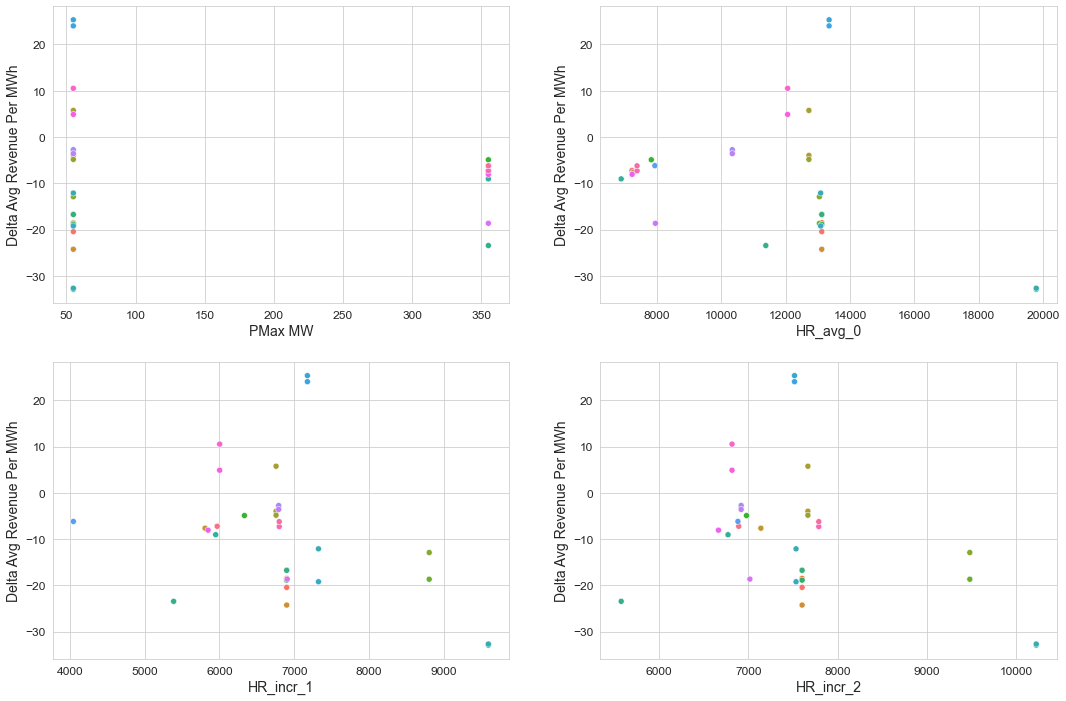

In [48]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
sns.scatterplot(ax=ax[0, 0],
    data=fit_df, y="Delta Avg Revenue Per MWh", x="PMax MW", hue="Generator", legend=False
)
sns.scatterplot(ax=ax[0, 1],
    data=fit_df, y="Delta Avg Revenue Per MWh", x="HR_avg_0", hue="Generator", legend=False
)
sns.scatterplot(ax=ax[1, 0],
    data=fit_df, y="Delta Avg Revenue Per MWh", x="HR_incr_1", hue="Generator", legend=False
)
sns.scatterplot(ax=ax[1, 1],
    data=fit_df, y="Delta Avg Revenue Per MWh", x="HR_incr_2", hue="Generator", legend=False
)

In [49]:
gen_df[gen_df['Generator'] == gen].resample("1M").sum()

,Output,Output DA,Curtailment,Unit Market Revenue,Unit Uplift Payment,Dispatch,Dispatch DA,Headroom,Unit Cost,LMP DA,LMP,Revenue DA,Revenue RT,Revenue,Revenue Per MWh,Revenue DA Per MWh,Revenue RT Per MWh
Datetime,,,,,,,,,,,,,,,,,
2020-01-31,0.0,0.0,0.0,7.181150e+05,0.0,17857.370864,18185.480472,17227.629136,7.364401e+05,13455.675250,10391.391288,5.541966e+05,16138.712090,5.703353e+05,2963.860968,2941.045769,38.777464
2020-02-29,0.0,0.0,0.0,1.198520e+06,0.0,34201.150033,33644.132876,32089.568241,1.229490e+06,13844.735301,28215.290526,9.571701e+05,102017.312925,1.059187e+06,5405.536567,5198.517888,352.522690
2020-03-31,0.0,0.0,0.0,1.015179e+06,0.0,25336.568197,26107.296568,24458.431803,1.034291e+06,14616.577590,23408.290327,8.584509e+05,-5225.541762,8.532253e+05,4480.369695,4533.001164,-50.319716
2020-04-30,0.0,0.0,0.0,8.990213e+05,0.0,20969.804130,20527.068892,17280.195870,9.366482e+05,14283.238864,27217.575166,7.520560e+05,89751.393350,8.418074e+05,4124.801690,3952.028133,267.530095
2020-05-31,0.0,0.0,0.0,1.537731e+06,0.0,39622.341737,39957.091141,38464.258263,1.581427e+06,15727.021978,19117.164949,1.292937e+06,17665.626919,1.310603e+06,7108.990405,7132.088640,25.116648
2020-06-30,0.0,0.0,0.0,2.708964e+06,0.0,65924.866708,67558.763591,62805.133293,2.393229e+06,17870.525039,17241.021066,2.305556e+06,169289.320373,2.474845e+06,12301.083126,12028.676462,336.422747
2020-07-31,0.0,0.0,0.0,4.080428e+06,0.0,104254.902728,108329.131246,99780.097272,3.316881e+06,21319.645350,19327.392223,3.628613e+06,-58938.755158,3.569675e+06,17973.391897,18408.436539,-475.739125
2020-08-31,0.0,0.0,0.0,3.869545e+06,0.0,93599.270554,98633.209996,91322.694444,3.124118e+06,21587.256593,17117.790694,3.458262e+06,-94009.522336,3.364252e+06,16927.598319,17413.775635,-588.025911
2020-09-30,0.0,0.0,0.0,2.534137e+06,0.0,62369.588398,65638.351145,60510.411601,2.262834e+06,18154.156715,15324.137100,2.252091e+06,-49890.311229,2.202200e+06,11162.334278,11499.855331,-393.054922


### Fit NN

In [50]:
%%script false --no-raise-error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Min Up Time Hr as state of charge required?
column_names = ['PMax MW', 'HR_avg_0', "Min Up Time Hr"]
column_names = ['PMax MW', 'PMin MW',
       'QMax MVAR', 'QMin MVAR', 'Min Down Time Hr', 'Min Up Time Hr',
       'Ramp Rate MW/Min', 'Start Time Cold Hr', 'Start Time Warm Hr',
       'Start Time Hot Hr', 'Start Heat Cold MBTU', 'Start Heat Warm MBTU',
       'Start Heat Hot MBTU', 'Output_pct_0',
       'Output_pct_1', 'Output_pct_2', 'Output_pct_3', 'Output_pct_4',
       'HR_avg_0', 'HR_incr_1', 'HR_incr_2', 'HR_incr_3', 'HR_incr_4', ]
column_names = ['PMax MW']
train_features = ng_df.copy()
train_features["Month"] = train_features.set_index("Datetime").index.month

for c in column_names:
    train_features[c] = -1
for gen in train_features['Generator'].unique():
    bid = bid_df[bid_df['Generator'] == gen]
    # for c in column_names:
        # train_features.loc[(ng_df['Generator'] == gen), c] = bid[c].unique()[0]

train_features = train_features.drop(columns=["Datetime", 'Generator', "Unit Market Revenue", 'Unit Uplift Payment', "Dispatch", 'Dispatch DA', 'Headroom', 'Unit Cost', 'Type'])
train_features = train_features.dropna(axis=1)
train_labels = train_features.pop('CF')

input_layer = layers.Input(train_features.shape[1:])

normalizer = layers.Normalization(input_shape=[9,], axis=None)
normalizer.adapt(train_features)
normalizer = normalizer(input_layer)

output_a = layers.Dense(1, activation='sigmoid')(normalizer)

output_b = layers.Dense(1)(normalizer) # This will be one of my outputs, so I want a linear activation

final_output = layers.Add()([output_a, output_b])
model = tf.keras.Model(input_layer, final_output)

def my_loss_fn(y_true, y_pred):
    # squared_difference = tf.square(y_true - y_pred)
    loss = abs(y_true - y_pred)
    # return tf.reduce_mean(squared_difference, axis=-1) 
    return tf.reduce_mean(loss, axis=-1) 

model.compile(loss=my_loss_fn,
                optimizer=tf.keras.optimizers.Adam(0.001))
display(model.summary())

history = model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()